# Predicting target variables using different models

### Prepare the training set (2017) and test set (2019) using 
https://github.com/sagerpascal/uzh-data-science-project/blob/main/WZ/Q5_datacleaning.ipynb

### Data downloaded from:
https://data.stadt-zuerich.ch/dataset/vbz_fahrgastzahlen_ogd
and
https://data.stadt-zuerich.ch/dataset/vbz_fahrzeiten_ogd

This script documents trials to predict VBZ public transportation vehicle occupancies (0 to 1) using data on year 2017 and validation on year 2019. Those years are chosen for the similarity in traffic volumes associated with different vehicle types.
In the output file from 
https://github.com/sagerpascal/uzh-data-science-project/blob/main/src/Q5_datacleaning.ipynb
we have feature variables in:
- Time
- GPS_Latitude
- GPS_Longitude
- Weekday
- Vehicle_type_
and additionally information about the maximum capacity of the vehicle, which is reserved for calculating the number of predicted empty seat ((1- Occupany) * Capacity)

Some trials were done using all the feature variables, while especially for svr because the training takes too long, the dataset was reduced to tram only.

As result of this training, we obtained models with prediction precision at:

Linear Regression MAPE on test set: 2144734221.059043
Linear Regression MAE on test set: 0.4593566554308329
Linear Regression MSE on test set: 0.4039692366610636
Random Forest MAPE on test set: 734290880.1453922
Random Forest MAE on test set: 0.36878384335316794
Random Forest MSE on test set: 0.2893897954651777
SVR MAPE on test set: inf
SVR MAE on test set: 0.4264129866667982
SVR MSE on test set: 0.40956721848620736

with the mean absolute error of the median predictor being: 0.687056532327459

For discussions, please take a look at out presentation (link in readme).


In [55]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# import umap
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import datetime
from joblib import dump

In [74]:
trainset = pd.read_csv('data/fahrgastzahlen_2017/cleaned.csv', sep=',')
testset = pd.read_csv('data/fahrgastzahlen_2019/cleaned.csv', sep=',')

In [76]:
# Too large (particularly for svr), keep only tram
trainset = trainset[trainset['Vehicle_type_T'] == True]
trainset = trainset.drop(columns = ['Nachtnetz', 'Vehicle_type_B', 'Vehicle_type_FB', 'Vehicle_type_N', 
                                    'Vehicle_type_SB', 'Vehicle_type_TR', 'Vehicle_type_T'])
testset = testset[testset['Vehicle_type_T'] == True]
testset = testset.drop(columns = ['Nachtnetz', 'Vehicle_type_B', 'Vehicle_type_FB', 'Vehicle_type_N', 
                                    'Vehicle_type_SB', 'Vehicle_type_TR', 'Vehicle_type_T'])

In [77]:
testset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 303949 entries, 619 to 576462
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Time           303949 non-null  float64
 1   Capacity       303949 non-null  float64
 2   Occupancy      303949 non-null  float64
 3   GPS_Latitude   303949 non-null  float64
 4   GPS_Longitude  303949 non-null  float64
 5   Weekday        303949 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 16.2 MB


In [7]:
trainset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199606 entries, 6680 to 374981
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Time           199606 non-null  float64
 1   Capacity       199606 non-null  float64
 2   Occupancy      199606 non-null  float64
 3   GPS_Latitude   199606 non-null  float64
 4   GPS_Longitude  199606 non-null  float64
 5   Weekday        199606 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 10.7 MB


In [78]:
# Fit the scaler on the training set only
scaler = StandardScaler()
columns_to_normalize = ['Time', 'GPS_Latitude', 'GPS_Longitude',
                        'Occupancy' 
                    # 'Capacity' only to use to restore the number of empty seats
                       ]
scaler.fit(trainset[columns_to_normalize])

# Transform both training and test sets
trainset[columns_to_normalize] = scaler.transform(trainset[columns_to_normalize])
testset[columns_to_normalize] = scaler.transform(testset[columns_to_normalize])

In [79]:
testset.head(10)

,Time,Capacity,Occupancy,GPS_Latitude,GPS_Longitude,Weekday
619,-1.544443,96.0,-1.095871,-0.626557,-0.924501,1
620,-1.544443,32.0,-0.259517,-0.626557,-0.924501,1
621,-1.544443,96.0,-0.688532,-0.626557,-0.924501,1
622,-1.365261,32.0,0.228457,-0.626557,-0.924501,1
623,-0.917307,96.0,-0.296973,-0.626557,-0.924501,1
624,-0.738125,32.0,0.920881,-0.626557,-0.924501,1
625,-0.738125,96.0,-0.537839,-0.626557,-0.924501,1
626,-0.738125,48.0,0.227590,-0.626557,-0.924501,1
627,-0.648534,44.0,0.018900,-0.626557,-0.924501,1
628,-0.469352,32.0,0.453716,-0.626557,-0.924501,1


In [80]:
X_train = trainset.drop(columns=['Capacity', 'Occupancy'])
y_train = trainset['Occupancy']
X_test = testset.drop(columns=['Capacity', 'Occupancy'])
y_test = testset['Occupancy']
X_train.head()

,Time,GPS_Latitude,GPS_Longitude,Weekday
6680,-1.634034,0.467447,-2.765563,1
6681,-1.454852,0.467447,-2.765563,1
6682,-1.454852,0.467447,-2.765563,1
6683,-1.365261,0.467447,-2.765563,1
6684,-1.365261,0.467447,-2.765563,1


In [ ]:
# If neccesary, take a smaller training set
X_train_s, X_val, y_train_s, y_val = train_test_split(X_train, y_train, test_size=0.8, random_state=42)

## Training models: linear regression and random forest with some GridSearchCV for best parameter

In [11]:
## Linear regression and random forest
# Define parameter grids for GridSearchCV, linear regression and random forest
param_grid_lr = {'fit_intercept': [True, False]}
# param_grid_rf = {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20]}
param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [10]}

# Initialize models, verbose=1 to show progress
lr = LinearRegression()
rf = RandomForestRegressor(verbose=1)

# GridSearchCV for Linear Regression
grid_lr = GridSearchCV(lr, param_grid_lr, cv=5, verbose=1)
grid_lr.fit(X_train, y_train)

# GridSearchCV for Random Forest
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, verbose=1)
grid_rf.fit(X_train, y_train)

print("Best parameters for Linear Regression:", grid_lr.best_params_)
print("Best parameters for Random Forest:", grid_rf.best_params_)

# Fit the training data with best parameters
best_lr = grid_lr.best_estimator_
best_lr.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_
best_rf.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    8.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

Best parameters for Linear Regression: {'fit_intercept': False}
Best parameters for Random Forest: {'max_depth': 10, 'n_estimators': 200}


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   19.6s finished


RandomForestRegressor(max_depth=10, n_estimators=200, verbose=1)

In [12]:
# Dump save trained model
# Get the current date and time
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

directory_path = 'models/'

lr_model_filename = f'{directory_path}linear_regression_model_{timestamp}.joblib'
rf_model_filename = f'{directory_path}random_forest_model_{timestamp}.joblib'

dump(best_lr, lr_model_filename)
dump(best_rf, rf_model_filename)

['models/random_forest_model_2024-05-14_22-18-31.joblib']

In [83]:
# Calculate the median of the predictions
median_y_train = np.median(y_train)

# Calculate the mean absolute error (MAE) of the median predictor
mae_med = np.mean(np.abs(y_train - median_y_train))
print(f"The mean absolute error of the median predictor is: {mae_med}")

The mean absolute error of the median predictor is: 0.687056532327459


In [86]:
# Check the metrics for predicting on the test set
# Predict on the test set
y_pred_lr = best_lr.predict(X_test)
y_pred_rf = best_rf.predict(X_test)

# Have to do this becasue the scaler was fitted on 4d data
testset_lr = testset.copy()
testset_rf = testset.copy()
testset_lr['Occupancy'] = y_pred_lr
testset_rf['Occupancy'] = y_pred_rf

# Reverse scale the y
testset_re = scaler.inverse_transform(testset[columns_to_normalize])
testset_lr_re = scaler.inverse_transform(testset_lr[columns_to_normalize])
testset_rf_re = scaler.inverse_transform(testset_rf[columns_to_normalize])

y_test_re = testset_re[:, 3]
y_pred_lr_re = testset_lr_re[:, 3]
y_pred_rf_re = testset_rf_re[:, 3]

# Calculate MAPE with a small denominator to prevent inf
mape_lr = np.mean(np.abs((y_test_re - y_pred_lr_re) / (y_test_re + 1e-10))) * 100
mape_rf = np.mean(np.abs((y_test_re - y_pred_rf_re) / (y_test_re + 1e-10))) * 100

# Calculate MAE 
mae_lr = mean_absolute_error(y_test_re, y_pred_lr_re)
mae_rf = mean_absolute_error(y_test_re, y_pred_rf_re)

# Calculate MSE
mse_lr = mean_squared_error(y_test_re, y_pred_lr_re)
mse_rf = mean_squared_error(y_test_re, y_pred_rf_re)

print("Linear Regression MAPE on test set:", mape_lr)
print("Linear Regression MAE on test set:", mae_lr)
print("Linear Regression MSE on test set:", mse_lr)

print("Random Forest MAPE on test set:", mape_rf)
print("Random Forest MAE on test set:", mae_rf)
print("Random Forest MSE on test set:", mse_rf)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Linear Regression MAPE on test set: 2144734221.059043
Linear Regression MAE on test set: 0.4593566554308329
Linear Regression MSE on test set: 0.4039692366610636
Random Forest MAPE on test set: 734290880.1453922
Random Forest MAE on test set: 0.36878384335316794
Random Forest MSE on test set: 0.2893897954651777


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.6s finished


In [87]:
# Check the metrics for predicting on the training set
y_pred_lr = best_lr.predict(X_train)
y_pred_rf = best_rf.predict(X_train)

trainset_lr = trainset.copy()
trainset_rf = trainset.copy()
trainset_lr['Occupancy'] = y_pred_lr
trainset_rf['Occupancy'] = y_pred_rf

# Reverse scale the y
# all scores looks quite differently if reverse scaling is not applied
trainset_re = scaler.inverse_transform(trainset[columns_to_normalize])
trainset_lr_re = scaler.inverse_transform(trainset_lr[columns_to_normalize])
trainset_rf_re = scaler.inverse_transform(trainset_rf[columns_to_normalize])

y_train_re = trainset_re[:, 3]
y_pred_lr_re = trainset_lr_re[:, 3]
y_pred_rf_re = trainset_rf_re[:, 3]

# Calculate MAPE with a small denominator to prevent inf
mape_lr = np.mean(np.abs((y_train_re - y_pred_lr_re) / (y_train_re + 1e-10))) * 100
mape_rf = np.mean(np.abs((y_train_re - y_pred_rf_re) / (y_train_re + 1e-10))) * 100

# Calculate MAE 
mae_lr = mean_absolute_error(y_train_re, y_pred_lr_re)
mae_rf = mean_absolute_error(y_train_re, y_pred_rf_re)

# Calculate MSE
mse_lr = mean_squared_error(y_train_re, y_pred_lr_re)
mse_rf = mean_squared_error(y_train_re, y_pred_rf_re)

print("Linear Regression MAPE on training set:", mape_lr)
print("Linear Regression MAE on training set:", mae_lr)
print("Linear Regression MSE on training set:", mse_lr)

print("Random Forest MAPE on training set:", mape_rf)
print("Random Forest MAE on training set:", mae_rf)
print("Random Forest MSE on training set:", mse_rf)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Linear Regression MAPE on training set: 968611893.8950824
Linear Regression MAE on training set: 0.42944108921576596
Linear Regression MSE on training set: 0.3530610111465693
Random Forest MAPE on training set: 384081718.01632553
Random Forest MAE on training set: 0.3410029712046899
Random Forest MSE on training set: 0.2490981985761064


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.2s finished


## Training model: SVR with some GridSearchCV for best parameter

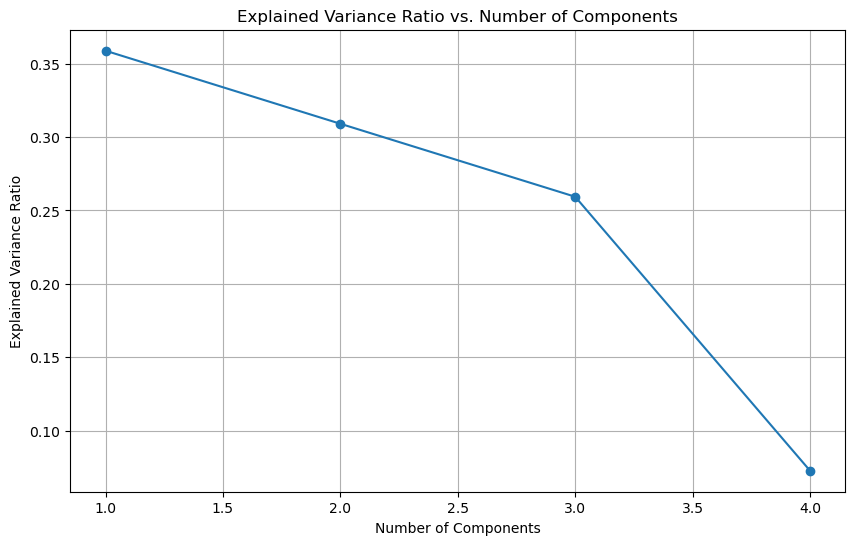

In [17]:
# See how many dimensions to set by PCA
pca = PCA()
pca.fit(X_train)

# Plot explained variance ratio to figure out how many dimensions to keep
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Components')
plt.grid(True)
plt.show()

In [20]:
# PCA-reduce dimension
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# X_train_s and y_train_s are 0.2 sized training set from 2017
# X_val and y_val are 0.8 sized validation set also 2017
# X_test and y_test are full-sized test set 2019

In [ ]:
# Simply fit into model
svr = SVR()
print("fitting")
svr.fit(X_train_pca, y_train)
print("fitting done!")

In [22]:
# Evaluate SVR model on r squared value
train_score = svr.score(X_train_pca, y_train)
print('score on training set acquired!')
test_score = svr.score(X_test_pca, y_test)
print('score on test set acquired!')

print("SVR Train Score:", train_score)
print("SVR Test Score:", test_score)

score on training set acquired!
score on validation set acquired!
SVR Train Score: 0.17670973763354014
SVR Validation Score: 0.15826277503819675


In [ ]:
###############################################################
## Option: If try grid search best params
# Probably should to use a smaller training set here
param_grid = {'C': [0.1, 1, 10]}

svr_model = SVR(kernel='rbf')

grid_svr = GridSearchCV(estimator=svr_model, param_grid=param_grid, cv=3, verbose=1)
grid_svr.fit(X_train_pca, y_train_s)

best_params = grid_svr.best_params_
best_score = grid_svr.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Fit the training data with best parameters
best_svr = grid_svr.best_estimator_
best_svr.fit(X_train_pca, y_train_s)


# Evaluate SVR model on r squared value
train_score = svr.score(X_train_pca, y_train_s)
print('score on training set acquired!')
test_score = svr.score(X_val_pca, y_val)
print('score on validation set acquired!')

print("SVR Train Score:", train_score)
print("SVR Validation Score:", test_score)

# takes around 10 mins for 0.2-sized tram only 2017

In [23]:
# Dump save trained model
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
directory_path = 'models/'

svr_model_filename = f'{directory_path}svr_model_{timestamp}.joblib'
dump(svr, svr_model_filename)

['models/svr_model_2024-05-15_10-55-34.joblib']

In [89]:
## Check the metrics of svr on test set
# Predict on the test set
X_test_pca = pca.fit_transform(X_test)
y_pred_svr = svr.predict(X_test_pca)

# Reverse scaling
testset_svr = testset.copy()
testset_svr['Occupancy'] = y_pred_svr

# Reverse scale the y
testset_re = scaler.inverse_transform(testset[columns_to_normalize])
testset_svr = scaler.inverse_transform(testset_svr[columns_to_normalize])

y_test_re = testset_re[:, 3]
y_pred_svr = testset_svr[:, 3]

mape_svr_te = np.mean(np.abs((y_test_re - y_pred_svr) / y_test_re + 1e-10)) * 100
mae_svr_te = mean_absolute_error(y_test_re, y_pred_svr)
mse_svr_te = mean_squared_error(y_test_re, y_pred_svr)

print("SVR MAPE on test:", mape_svr_te)
print("SVR MAE on test:", mae_svr_te)
print("SVR MSE on test:", mse_svr_te)

SVR MAPE on test: inf
SVR MAE on test: 0.4264129866667982
SVR MSE on test: 0.40956721848620736


/var/folders/3x/sr1q_hx933vd7k4mcn3sxx4r0000gp/T/ipykernel_87430/3777791972.py:12: RuntimeWarning: divide by zero encountered in divide
  mape_svr_te = np.mean(np.abs((y_test_re - y_pred_svr) / y_test_re + 1e-10)) * 100


In [ ]:
## Check the metrics of svr on training set
# Predict on the training set
X_train_pca = pca.fit_transform(X_train) # fullset
y_pred_svr = svr.predict(X_train_pca)

mape_svr_tr = np.mean(np.abs((y_train - y_pred_svr) / y_test + 1e-10)) * 100
mae_svr_tr = mean_absolute_error(y_train, y_pred_svr)
mse_svr_tr = mean_squared_error(y_train, y_pred_svr)

print("SVR MAPE on train:", mape_svr_tr)
print("SVR MAE on train:", mae_svr_tr)
print("SVR MSE on train:", mse_svr_tr)

### Discarded

In [90]:
# Check the metrics for predicting on the test set without reverse scaling, for lr and rf
# Predict on the test set
y_pred_lr = best_lr.predict(X_test)
y_pred_rf = best_rf.predict(X_test)

# Calculate MAPE with a small denominator to prevent inf
mape_lr = np.mean(np.abs((y_test - y_pred_lr) / (y_test + 1e-10))) * 100
mape_rf = np.mean(np.abs((y_test - y_pred_rf) / (y_test + 1e-10))) * 100

# Calculate MAE 
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

# Calculate MSE
mse_lr = mean_squared_error(y_test, y_pred_lr)
mse_rf = mean_squared_error(y_test, y_pred_rf)

print("Linear Regression MAPE on test set:", mape_lr)
print("Linear Regression MAE on test set:", mae_lr)
print("Linear Regression MSE on test set:", mse_lr)

print("Random Forest MAPE on test set:", mape_rf)
print("Random Forest MAE on test set:", mae_rf)
print("Random Forest MSE on test set:", mse_rf)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Linear Regression MAPE on test set: 201.64348264511864
Linear Regression MAE on test set: 0.7647051788651441
Linear Regression MSE on test set: 1.1195315325049027
Random Forest MAPE on test set: 477.58859257554855
Random Forest MAE on test set: 0.613925827698001
Random Forest MSE on test set: 0.8019942406659941


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.8s finished


In [91]:
# Check the metrics for predicting on the training set without reverse scaling, for lr and rf
y_pred_lr = best_lr.predict(X_train)
y_pred_rf = best_rf.predict(X_train)

# Calculate MAPE with a small denominator to prevent inf
mape_lr = np.mean(np.abs((y_train - y_pred_lr) / (y_train + 1e-10))) * 100
mape_rf = np.mean(np.abs((y_train - y_pred_rf) / (y_train + 1e-10))) * 100

# Calculate MAE 
mae_lr = mean_absolute_error(y_train, y_pred_lr)
mae_rf = mean_absolute_error(y_train, y_pred_rf)

# Calculate MSE
mse_lr = mean_squared_error(y_train, y_pred_lr)
mse_rf = mean_squared_error(y_train, y_pred_rf)

print("Linear Regression MAPE on training set:", mape_lr)
print("Linear Regression MAE on training set:", mae_lr)
print("Linear Regression MSE on training set:", mse_lr)

print("Random Forest MAPE on training set:", mape_rf)
print("Random Forest MAE on training set:", mae_rf)
print("Random Forest MSE on training set:", mse_rf)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Linear Regression MAPE on training set: 183.02961228110286
Linear Regression MAE on training set: 0.7149038139716958
Linear Regression MSE on training set: 0.9784481069489978
Random Forest MAPE on training set: 384.440135763696
Random Forest MAE on training set: 0.5676781537954502
Random Forest MSE on training set: 0.6903329825337616


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.2s finished


In [ ]:
# Findout a good dimension number for UMAP <- takes forever, discard
dimensions_to_try = [2]

# Plot each dimensionality reduction
 for n_components in dimensions_to_try:
     Reduce dimensionality using UMAP
     reducer = umap.UMAP(n_components=n_components)
     X_umap = reducer.fit_transform(X_train)
    
     plt.figure(figsize=(8, 6))
     if n_components == 2:
        plt.scatter(X_umap[:, 0], X_umap[:, 1], alpha=0.5)
        plt.title("UMAP (2D)")
     elif n_components == 3:
        ax = plt.axes(projection='3d')
        ax.scatter3D(X_umap[:, 0], X_umap[:, 1], X_umap[:, 2], alpha=0.5)
        ax.set_title("UMAP (3D)")
     elif n_components == 4:
        ax

In [ ]:
## SVR
# Try with SVR with UMAP dimension reduction <- Always fails at spectral initialization
# Reduce dimensionality using UMAP
reducer = umap.UMAP(n_components=2)
X_train_umap = reducer.fit_transform(X_train)
X_test_umap = reducer.transform(X_test)


svr = SVR()
svr.fit(X_train_umap, y_train)

# Evaluate SVR model on r squared value
train_score = svr.score(X_train_umap, y_train)
test_score = svr.score(X_test_umap, y_test)

print("SVR Train Score:", train_score)
print("SVR Test Score:", test_score)

In [ ]:
## Check the metrics of svr on test set
X_test_pca = pca.fit_transform(X_test)
# Predict on the test set
y_pred_svr = svr.predict(X_test_pca)

mape_svr_te = np.mean(np.abs((y_test - y_pred_svr) / y_test + 1e-10)) * 100
mae_svr_te = mean_absolute_error(y_test, y_pred_svr)
mse_svr_te = mean_squared_error(y_test, y_pred_svr)

print("SVR MAPE on test:", mape_svr_te)
print("SVR MAE on test:", mae_svr_te)
print("SVR MSE on test:", mse_svr_te)

## Check the metrics of svr on training set
# Predict on the training set
X_train_pca = pca.fit_transform(X_train) # fullset
y_pred_svr = svr.predict(X_train_pca)

mape_svr_tr = np.mean(np.abs((y_train - y_pred_svr) / y_test + 1e-10)) * 100
mae_svr_tr = mean_absolute_error(y_train, y_pred_svr)
mse_svr_tr = mean_squared_error(y_train, y_pred_svr)

print("SVR MAPE on train:", mape_svr_tr)
print("SVR MAE on train:", mae_svr_tr)
print("SVR MSE on train:", mse_svr_tr)

## Remarks:
Change to train with 2017 data to predict 2019 data for better similarity in volume with vehicle types (planned to use 2022/2023)
see https://github.com/Chocobosaurus/uzh-data-science-project/blob/main/WZ/Q1Q2.md

In [ ]:
# Models:
# 2024-05-14_15-59-58: Done with unormalized Occupancy, with vehicle type. lr + rf
# 2024-05-14_16-49-07: Done with normalized Occupancy, with vehicle type. lr + rf
# 2024-05-14_17-16-45: Done with normalized Occupanct, 2017 as training set. lr + rf
# 2024-05-14_20-29-31: 0.2-sized tram only 2017, svr.
# 2024-05-14_21-57-38: 0.2-sized tram only 2017, svr with grid search. C=10.
# 2024-05-14_22-18-31: tram only 2017, lr + rf.
# model_2024-05-15_10-55-34: tram only 2017, svr.